This notebook is a template for your homework assignment, it is only for students participating in the course Physical Attacks and Countermeasures

This material is instructional content and copyrighted; do not copy, share, or distribute without permission

Do not publicly upload your own solution anywhere, as this is a prohibited behavior according to Oregon State University policies

In [1]:
import numpy as np
from numba import njit, prange
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# High-performance oriented programming habits
## The good
+ reuse and preallocate variables
+ precompute data when possible; access when needed
+ vectorize whenever possible (we will practice together)
+ think about complementary approaches (sometimes easier to compute)
+ check variable data types (even in Python); only start this if result OK
## The bad
+ nested for-loops
+ branching; especially in nested loops
+ dynamically changing array sizes
## The ugly
+ np.vectorize is a for-loop 'wrapper'
+ not profiling your code
+ asking for a GPU without knowing why
## Please note
+ me=lazy programmer
+ same as you, I'm still learning Python3
+ and slow at typing (no jokes please while actively coding in class :-))

In [2]:
# not optimized; for your reference
sbox = np.array([
0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76,
0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0,
0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15,
0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75,
0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84,
0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf,
0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8,
0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2,
0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73,
0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb,
0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79,
0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08,
0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a,
0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e,
0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf,
0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16
], dtype=np.uint8)

In [3]:

timings = np.loadtxt('timing_noisy.csv', delimiter=',')
timings.shape
plaintext = timings[:,range(16)].astype(np.int32)
timing_data = timings[:, -1].astype(np.float32)


In [4]:
np.shape(plaintext)

(1000000, 16)

# Attack Recipe from Slides
+ Note: n = number of samples; corresponds to rows of .csv
+ Attacker guesses a value K as key candidate for the key
    + Create two groups: group1 and group0
    + for i = 1 to n compute Sbox(firstbyte(p_i) XOR k) – this will be our ‘hypothesis’
    + If MSB of result is 1, the corresponding timing t_i goes to group1, otherwise to group0
    + On average, the timings of group1 should be higher than of group0
    + Averaging helps to get this information and reduce noise
    + The difference between averages of two groups is assigned guessed key byte k
    + This step needs to be repeated for all key candidates 𝐾 = 0 . . . 255
+ The highest difference between the averages shows the most probable value candidate for the key

In [5]:

@njit
def recover_key_byte_grouping(plaintexts, timings, byte_index):
    max_diff = 0.0
    guesses_value_k = 0
    n_samples = len(plaintexts)
    max_diffs = np.zeros(256)

    for k in range(256):
        sum_group1 = 0.0
        sum_group0 = 0.0
        count_group1 = 0
        count_group0 = 0

        for i in range(n_samples):
            hypothesis = sbox[plaintexts[i, byte_index] ^ k]
            if hypothesis >> 7:
                sum_group1 += timings[i]
                count_group1 += 1
            else:
                sum_group0 += timings[i]
                count_group0 += 1

        avg_group1 = sum_group1 / count_group1 if count_group1 > 0 else 0.0
        avg_group0 = sum_group0 / count_group0 if count_group0 > 0 else 0.0
        diff = abs(avg_group1 - avg_group0)
        max_diffs[k] = diff

        if diff > max_diff:
            max_diff = diff
            guesses_value_k = k

    return guesses_value_k, max_diffs

@njit(parallel=True)
def parallel_recover_grouping(plaintext, timing_data, n_samples):
    recovered_key = np.empty(16, dtype=np.uint8)
    all_max_diffs = np.empty((16, 256), dtype=np.float32)
    for i in prange(16):
        recovered_key[i], all_max_diffs[i] = recover_key_byte_grouping(plaintext[:n_samples], timing_data[:n_samples], i)
    return recovered_key, all_max_diffs

num_samples = [1000, 10000, 50000, 100000, 500000, 1000000]
recovered_keys = []
all_max_diffs_list = []

for n in num_samples:
    recovered_key, all_max_diffs = parallel_recover_grouping(plaintext, timing_data, n)
    recovered_keys.append(recovered_key)
    all_max_diffs_list.append(all_max_diffs)
    print(f"Recovered key for {n} samples: {recovered_key}")

if recovered_keys:
    correct_key = recovered_keys[-1]
    all_max_diffs = all_max_diffs_list[-1]
    print(f"\nCorrect recovered key: {correct_key}")
else:
    print("correct_key is not defined.")

start_time = time.time()
recovered_key, all_max_diffs = parallel_recover_grouping(plaintext, timing_data, n)
end_time = time.time()

print(f"Time for {n} samples: {end_time - start_time} seconds")



Recovered key for 1000 samples: [193  70 140 220  27 120  66  39  32 221  95 220  38 228 238 134]
Recovered key for 10000 samples: [ 85 247 185  82  45 161 200 185  73  92  62  64 168 191  71 147]
Recovered key for 50000 samples: [ 85  41  79  30 155  34 217 216   8  82 185 223 236 239  47  12]
Recovered key for 100000 samples: [176 142  79  30 183 104  89  71 251  49 185 223 236 239  47 176]
Recovered key for 500000 samples: [ 41 142  79  30 183 104 193  19  15 246 189 223 236 119  47 176]
Recovered key for 1000000 samples: [ 41 142  79  30 183 104 193  19  15 246 189 223 236 119  47 176]

Correct recovered key: [ 41 142  79  30 183 104 193  19  15 246 189 223 236 119  47 176]
Time for 1000000 samples: 2.089872360229492 seconds


Processing 100000 samples
Processing 200000 samples
Processing 300000 samples
Processing 400000 samples
Processing 500000 samples
Processing 600000 samples
Processing 700000 samples
Processing 800000 samples
Processing 900000 samples
Key byte 0: samples needed = 200000
Key byte 1: samples needed = 100000
Key byte 2: samples needed = 100000
Key byte 3: samples needed = 100000
Key byte 4: samples needed = 100000
Key byte 5: samples needed = 100000
Key byte 6: samples needed = 200000
Key byte 7: samples needed = 200000
Key byte 8: samples needed = 200000
Key byte 9: samples needed = 200000
Key byte 10: samples needed = 200000
Key byte 11: samples needed = 100000
Key byte 12: samples needed = 100000
Key byte 13: samples needed = 200000
Key byte 14: samples needed = 100000
Key byte 15: samples needed = 100000


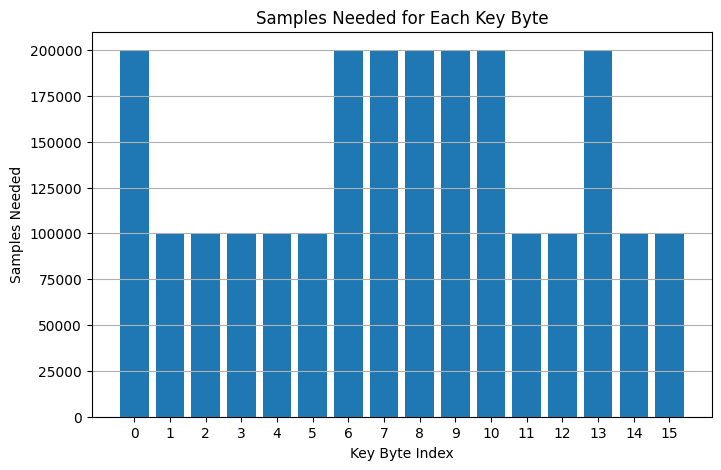

In [6]:
## insert your code here

num_samples2 = np.arange(100000, 1000000, 100000)
min_samples_needed = np.full(16, np.inf)

for n in num_samples2:
    print(f"Processing {n} samples")
    recovered_key, _ = parallel_recover_grouping(plaintext, timing_data, n)

    for i in range(16):
        if min_samples_needed[i] == np.inf and recovered_key[i] == correct_key[i]:
            min_samples_needed[i] = n

min_samples_needed[min_samples_needed == np.inf] = num_samples2[-1]

for i in range(16):
    print(f"Key byte {i}: samples needed = {int(min_samples_needed[i])}")

plt.figure(figsize=(8, 5))
plt.bar(range(16), min_samples_needed)
plt.xlabel("Key Byte Index")
plt.ylabel("Samples Needed")
plt.title("Samples Needed for Each Key Byte")
plt.xticks(range(16))
plt.grid(axis="y")
plt.show()


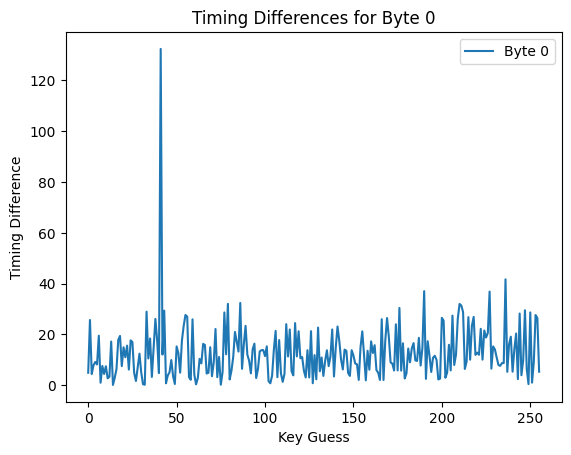

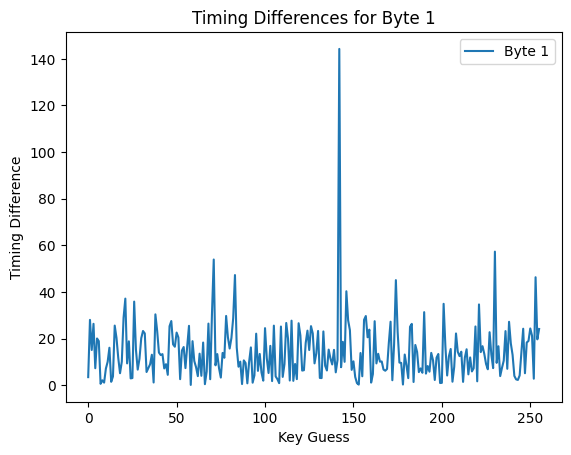

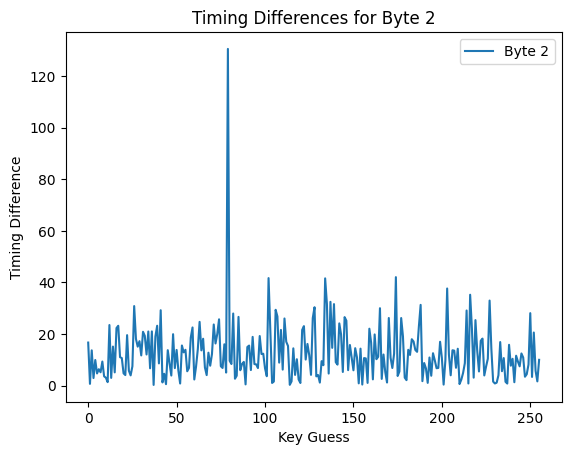

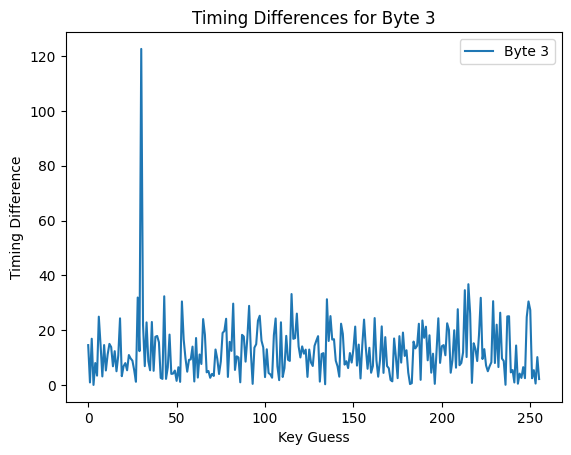

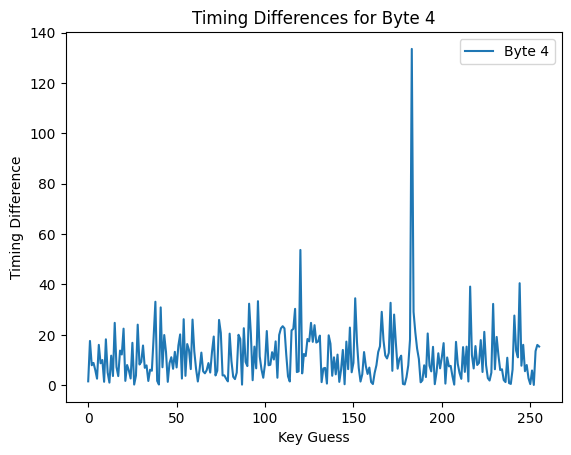

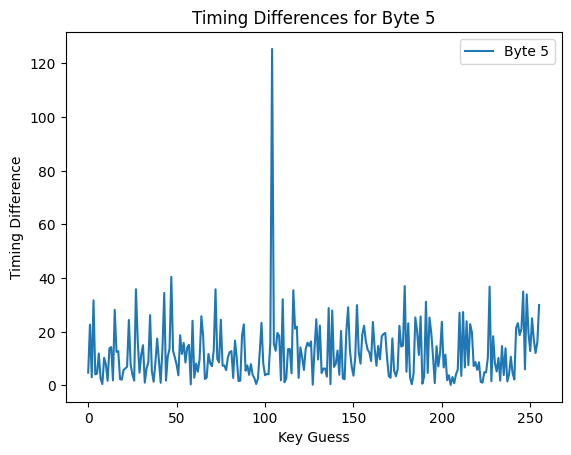

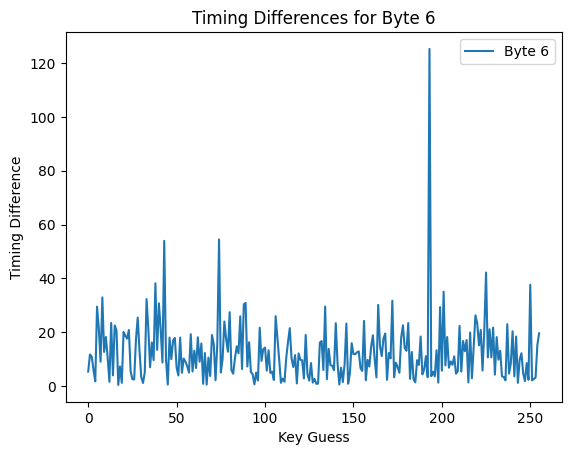

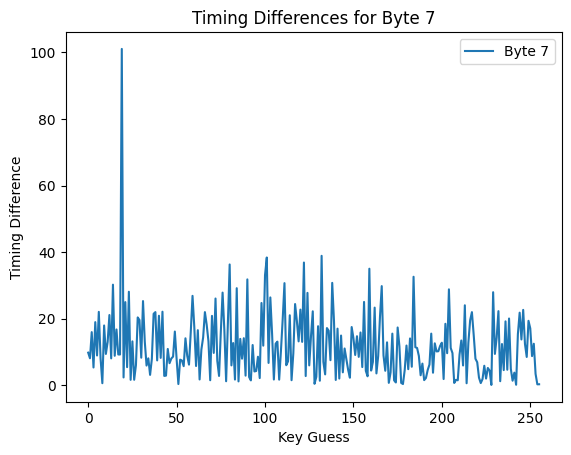

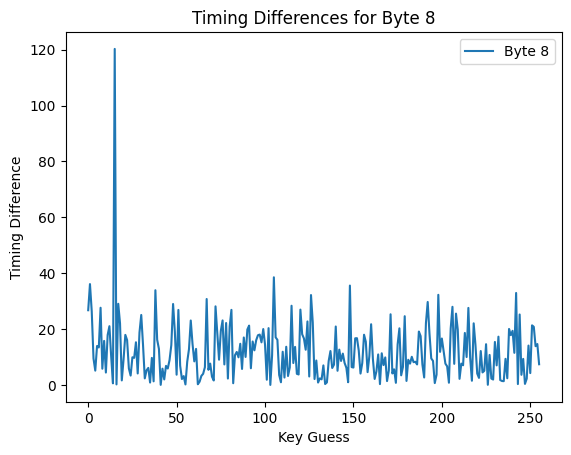

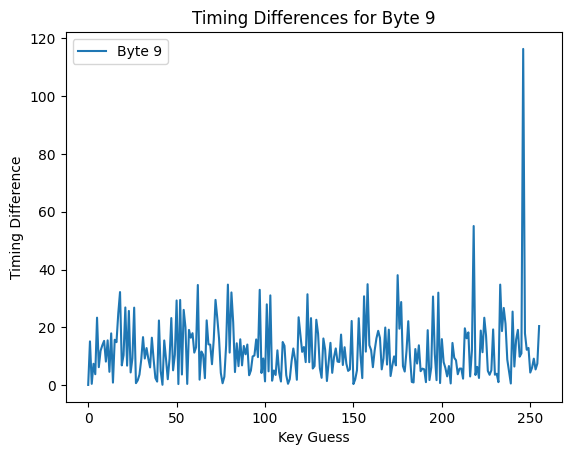

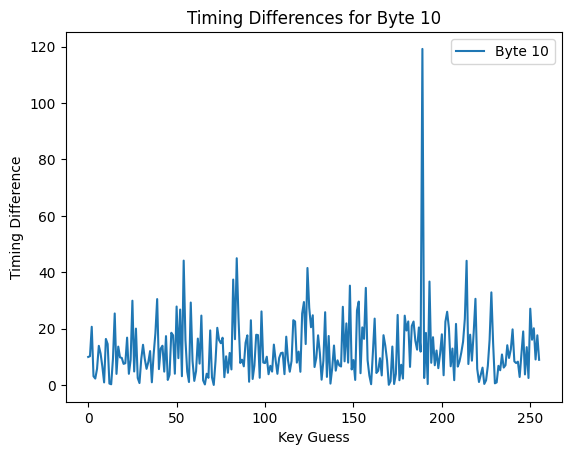

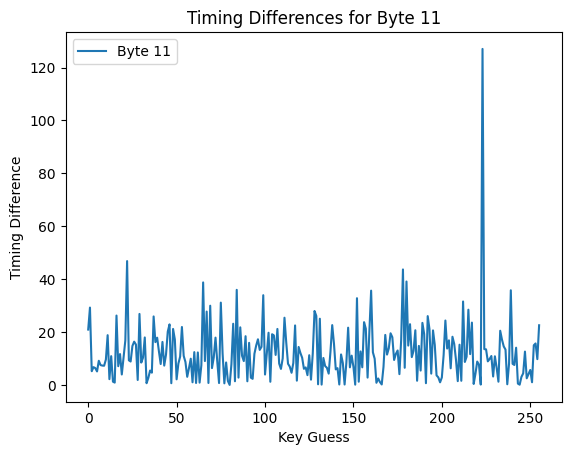

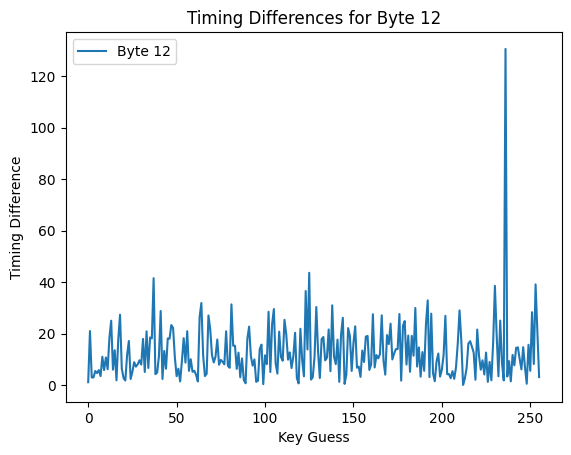

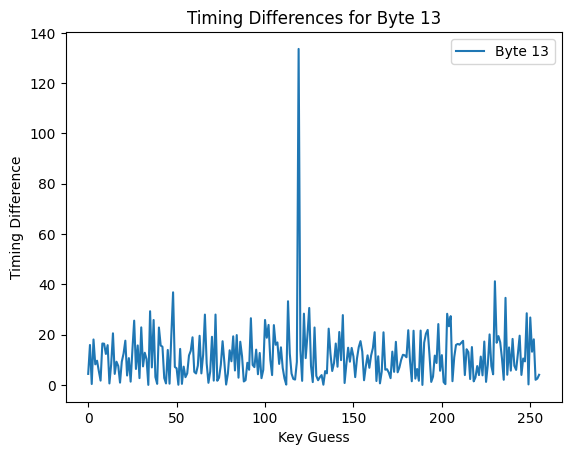

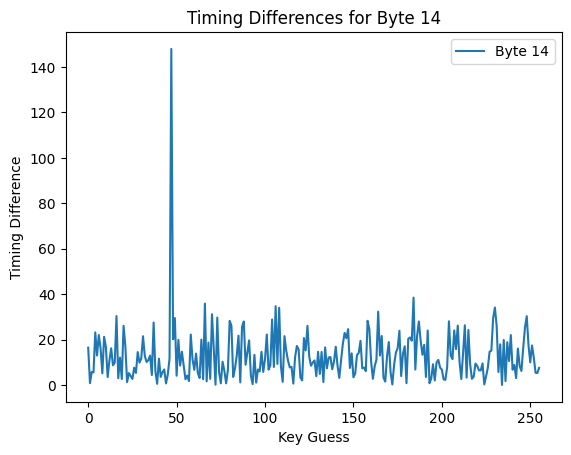

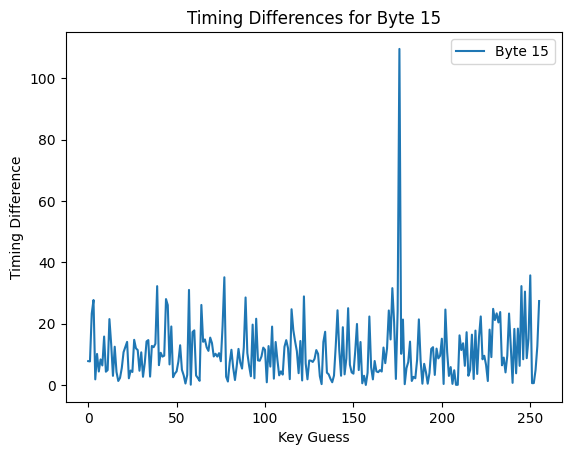

In [7]:
for byte_index in range(16):
    plt.figure()
    plt.plot(range(256), all_max_diffs[byte_index], label=f'Byte {byte_index}')
    plt.xlabel('Key Guess')
    plt.ylabel('Timing Difference')
    plt.title(f'Timing Differences for Byte {byte_index}')
    plt.legend()
    plt.show()

Please verify your result by plottng the timing differences. For each attacked byte, there will only be one clearly visible peak.